In [11]:
import os
import predict
import importlib
import tensorflow as tf
from openbabel import pybel
from glob import glob

# CASR_HiQ_NRC_set

In [7]:
dirs1 = glob('CSAR_NRC_HiQ_Set/Structures/set1/*')
dirs1.sort()
dirs2 = glob('CSAR_NRC_HiQ_Set/Structures/set2/*')
dirs2.sort()

In [8]:
for d in dirs1:
    n = os.path.split(d)[-1]
    complex_name = d+'/set1_'+n+'_complex.mol2'
    tmp1_name = d+'/tmp1.pdb'
    plcomplex = next(pybel.readfile('mol2', complex_name))
    plcomplex.write('pdb', tmp1_name, overwrite=True)

In [9]:
for d in dirs2:
    n = os.path.split(d)[-1]
    complex_name = d+'/set2_'+n+'_complex.mol2'
    tmp1_name = d+'/tmp1.pdb'
    plcomplex = next(pybel.readfile('mol2', complex_name))
    plcomplex.write('pdb', tmp1_name, overwrite=True)

In [22]:
aa = []
for d in dirs1:
    n = os.path.split(d)[-1]
    complex_name = d+'/set1_'+n+'_complex.mol2'
    tmp1_name = d+'/tmp1.pdb'
#    plcomplex = next(pybel.readfile('mol2', complex_name))
#    plcomplex.write('pdb', tmp1_name, overwrite=True)
    with open(tmp1_name, 'r') as f:
        for line in f.readlines():
            if line[:4] == 'ATOM':
                if line[17:20] not in aa:
                    aa.append(line[17:20])

In [28]:
for d in dirs2:
    n = os.path.split(d)[-1]
#    complex_name = d+'/set2_'+n+'_complex.mol2'
    tmp1_name = d+'/tmp1.pdb'
#    plcomplex = next(pybel.readfile('mol2', complex_name))
#    plcomplex.write('pdb', tmp1_name, overwrite=True)
    with open(tmp1_name, 'r') as f:
        for line in f.readlines():
            if line[:4] == 'ATOM':
                if line[17:20] not in aa:
                    aa.append(line[17:20])

In [36]:
for d in dirs1:
    flag = 0
    tmp1_name = d+'/tmp1.pdb'
    with open(tmp1_name, 'r') as f:
        for line in f.readlines():
            if line[17:20] == 'INH':
                flag = 1
                break
        if flag == 0:
            print(d)
            
#all ligands are named by 'INH'            

In [10]:
for d in dirs1:
    tmp1_name = d+'/tmp1.pdb'
    tmp2_name = d+'/tmp2.pdb'
    tmp3_name = d+'/tmp3.pdb'
    f2 = open(tmp2_name, 'w')
    f3 = open(tmp3_name, 'w')
    with open(tmp1_name, 'r') as f:
        for line in f.readlines():
            if line[:4] == 'ATOM':
                if line[17:20] == 'INH':
                    f3.write(line)
                else:
                    f2.write(line)   
    f2.close()
    f3.close()
#tmp2.pdb   protein
#tmp3.pdb   ligand

In [11]:
for d in dirs2:
    tmp1_name = d+'/tmp1.pdb'
    tmp2_name = d+'/tmp2.pdb'
    tmp3_name = d+'/tmp3.pdb'
    f2 = open(tmp2_name, 'w')
    f3 = open(tmp3_name, 'w')
    with open(tmp1_name, 'r') as f:
        for line in f.readlines():
            if line[:4] == 'ATOM':
                if line[17:20] == 'INH':
                    f3.write(line)
                else:
                    f2.write(line)   
    f2.close()
    f3.close()  

In [ ]:
#set1_1_complex.mol2
importlib.reload(predict)
model = predict.build_model()
with open('evaluation_set1_complex.csv', 'w') as f1:
    f1.write('#id\tscore\n')
    for d in dirs1:
        n = os.path.split(d)[-1]
        proteinfile = d+'/tmp2.pdb'
        ligandfile = d+'/tmp3.pdb'
        protein = next(pybel.readfile('pdb',proteinfile))
        ligand = next(pybel.readfile('pdb',ligandfile))
        result = predict.predict(protein, ligand, model)
        f1.write(n+'\t%.4f\n' % result)   

In [46]:
#set2_1_complex.mol2
importlib.reload(predict)
model = predict.build_model()
with open('evaluation_set2_complex.csv', 'w') as f1:
    f1.write('#id\tscore\n')
    for d in dirs2:
        n = os.path.split(d)[-1]
        proteinfile = d+'/tmp2.pdb'
        ligandfile = d+'/tmp3.pdb'
        protein = next(pybel.readfile('pdb',proteinfile))
        ligand = next(pybel.readfile('pdb',ligandfile))
        result = predict.predict(protein, ligand, model)
        f1.write(n+'\t%.4f\n' % result)      


In [26]:
csarkd = ''
for d in dirs1:
    kd_name = d+'/kd.dat'
    with open(kd_name, 'r') as f:
        csarkd += f.readline() 
with open('set1_kd.csv', 'w') as f:
    f.write(csarkd)       

In [ ]:
csarkd = ''
for d in dirs2:
    kd_name = d+'/kd.dat'
    with open(kd_name, 'r') as f:
        csarkd += f.readline() 
with open('set2_kd.csv', 'w') as f:
    f.write(csarkd)    

### analysis

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [47]:
dfset1 = pd.read_csv('set1_kd.csv',header=None,names=['#id','pdbid','true'])
dfpre = pd.read_csv('evaluation_set1_complex.csv',sep='\t')
df=pd.merge(dfset1,dfpre,on='#id')
df.to_csv('set1_complex.csv',index=None)

In [50]:
df[['true','score']].corr() 

,true,score
true,1.000000,0.867247
score,0.867247,1.000000


In [ ]:
dfset2 = pd.read_csv('set2_kd.csv',header=None,names=['#id','pdbid','true'])
dfpre = pd.read_csv('evaluation_set2_complex.csv',sep='\t')
df=pd.merge(dfset2,dfpre,on='#id')
df.to_csv('set2_complex.csv',index=None)

In [ ]:
complex:    set2: 0.8684        set1: 0.7840
exclude overlap:  set2: #78, 0.7452,  1.5027,  1.1427,  1.4793               set1: #71,  0.6311  #R,  2.0924  #rmse,   1.6155   #mae,   2.1001

In [12]:
train_dirs = glob(os.path.join('trainset','*'))
train_dirs.sort()
train_id = [os.path.split(i)[-1] for i in train_dirs]

In [2]:
df1 = pd.read_csv('set1_complex.csv')
df2 = pd.read_csv('set2_complex.csv')

In [3]:
dfall = pd.concat([df1,df2], axis = 0)

In [7]:
dfall[['true','score']].corr() 

,true,score
true,1.000000,0.823992
score,0.823992,1.000000


In [8]:
np.sqrt(np.mean((dfall['true']-dfall['score'])**2))    ###rmse

1.2770677130680785

In [9]:
np.mean(np.abs(dfall['true']-dfall['score'])) 

0.8375104956268224

### exclud overlaps

In [13]:
df1=df1[~df1.pdbid.str[1:5].isin(train_id)]
df2=df2[~df2.pdbid.str[1:5].isin(train_id)]

In [14]:
df = pd.concat([df1,df2], axis = 0)

In [15]:
df

,#id,pdbid,true,score
0,1,1w6o,3.34,3.5811
2,102,2qeh,8.62,5.0152
3,103,2qvu,6.44,3.9206
4,104,2r3d,-0.15,4.0153
6,106,2rde,7.01,6.5830
...,...,...,...,...
158,88,1s38,5.15,6.3772
161,92,1sw1,7.30,6.6355
163,96,1syi,5.48,5.2428
164,97,1toj,3.39,4.7673


In [16]:
df[['true','score']].corr() 

,true,score
true,1.00000,0.67575
score,0.67575,1.00000


In [17]:
np.sqrt(np.mean((df['true']-df['score'])**2))    ###rmse

1.8078527532358797

In [18]:
np.mean(np.abs(df['true']-df['score'])) 

1.3680181208053692

# astex

In [40]:
dirs = glob('astex_diverse_set/*')
dirs.sort()

In [41]:
len(dirs)

85

In [6]:
for d in dirs:
    proteinfile = d+'/protein.mol2'
    protein=next(pybel.readfile('mol2',proteinfile))
    protein.write('pdb', d+'/tmp.pdb', overwrite=True)

In [11]:
importlib.reload(predict)
model = predict.build_model()
with open('evaluation_astex.csv', 'a') as f1:
    f1.write('#id\tscore\n')
    for d in dirs:
        n = os.path.split(d)[-1]
        proteinfile = d+'/tmp.pdb'
        ligandfile = d+'/ligand.mol'
        protein = next(pybel.readfile('pdb',proteinfile))
        ligand = next(pybel.readfile('mol',ligandfile))
        result = predict.predict(protein, ligand, model)
        f1.write(n+'\t%.4f\n' % result)      

In [34]:
df=pd.read_csv('evaluation_astex.csv')
df=df[['id','no','cs','gs','uM','pkd','flag']]

In [42]:
df=df[~df.id.isin(train_id)]

In [47]:
df

,id,no,cs,gs,uM,pkd,flag
2,1gm8,4.2294,4.1739,4.1866,16.000,4.795880,4
3,1gpk,7.0961,7.1679,7.1279,4.300,5.366532,2
4,1hnn,6.1904,6.1998,6.2130,0.580,6.236572,2
5,1hp0,5.3715,5.3960,5.3411,0.200,6.698970,2
6,1hq2,5.2207,5.2957,5.2944,0.170,6.769551,2
...,...,...,...,...,...,...,...
80,1ywr,8.5442,8.6044,8.5874,0.032,7.494850,1
81,1z95,8.9788,8.9973,8.9973,0.076,7.119186,2
82,2bm2,5.6437,5.6585,5.6573,0.015,7.823909,2
83,2br1,6.5242,6.5335,6.5464,15.400,4.812479,1


In [46]:
df=df[df.flag!=0]

In [48]:
df[['no','pkd']].corr() 

,no,pkd
no,1.000000,0.647432
pkd,0.647432,1.000000


In [71]:
np.sqrt(np.mean((df['no']-df['pkd'])**2))    ###rmse

1.3626550029016888

In [72]:
np.mean(np.abs(df['no']-df['pkd'])) 

1.051848235148649

In [73]:
regr=linear_model.LinearRegression()
x=df['no'].values.reshape(-1,1)
y=df['pkd'].values.reshape(-1,1)
regr.fit(x,y)
y_ = regr.predict(x)
np.sqrt(sum((y-y_)**2)/73)

array([1.3108791])

## vinaRF

In [16]:
rf2014 = []
with open('INDEX_refined_name.2014', 'r') as f:
    for line in f.readlines():
        if line[0] != '#':
            rf2014.append(line[:4])

In [15]:
from glob import glob
import os

In [17]:
core_dirs = glob(os.path.join('CASF-2013','CASF-2013','coreset','*'))
core_dirs.sort()
core_2013 = [os.path.split(i)[-1] for i in core_dirs]

In [18]:
core_2007 = []
with open('PDBbind_core_set_v2007.2.lst', 'r') as f:
    for line in f.readlines():
        if line[0] != '#':
            core_2007.append(line[:4])

In [19]:
core_dirs = glob(os.path.join('CASF-2016','CASF-2016','coreset','*'))
core_dirs.sort()
core_2016 = [os.path.split(i)[-1] for i in core_dirs]

In [9]:
rf2014_new = []
for i in rf2014:
    if i not in core_2013 and i not in core_2007:
        rf2014_new.append(i)

In [8]:
len(core_2013)

195

In [10]:
len(rf2014)

3446

In [12]:
len(rf2014_new)

3113

In [13]:
overlap = []
for i in rf2014_new:
    if i in core_2016:
        overlap.append(i)

In [14]:
len(overlap)

140

In [21]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

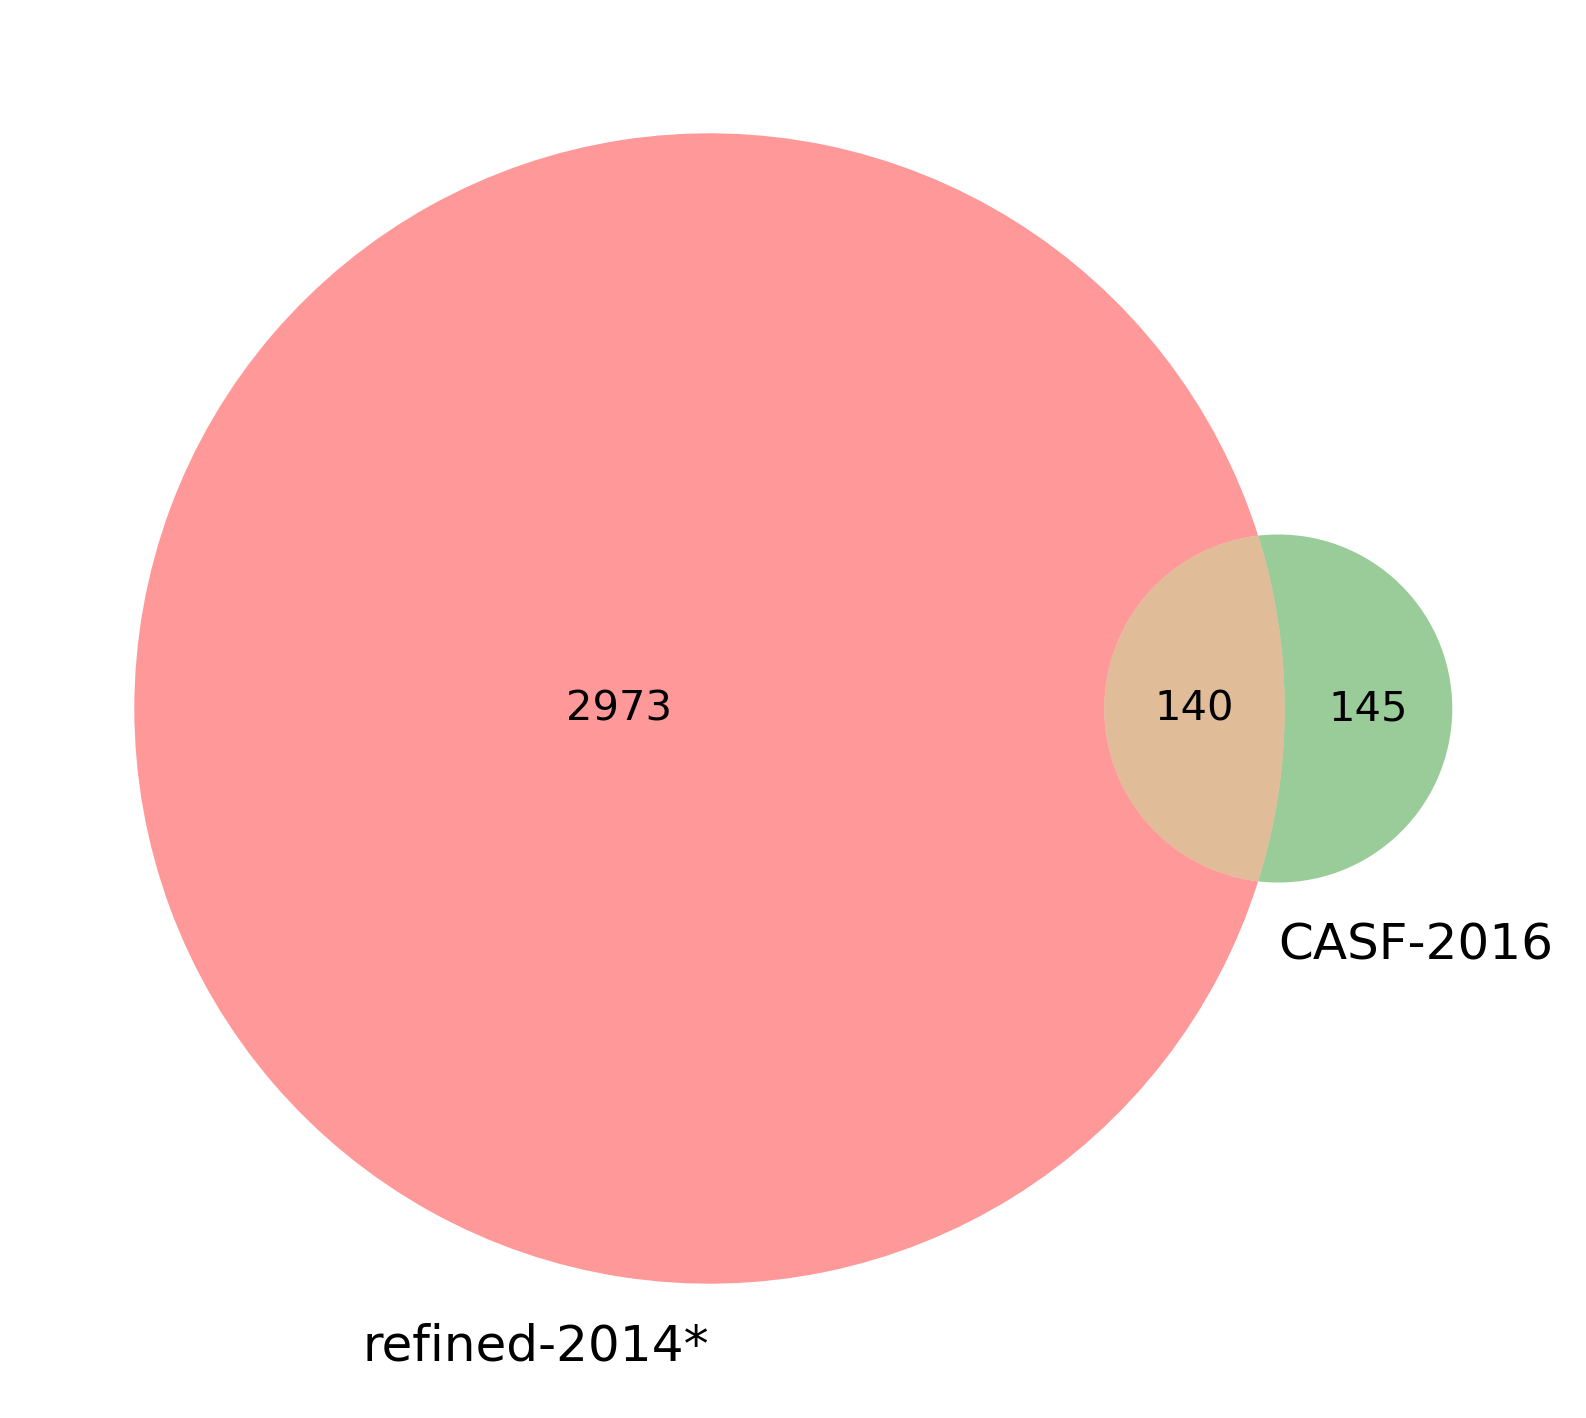

In [30]:
my_dpi=600
plt.figure(figsize=(8,6),dpi=300)
venn2(subsets=[set(rf2014_new),set(core_2016)],set_labels = ('refined-2014*','CASF-2016'))
plt.savefig('vinarf-venn.tif')

# pafnucy

In [50]:
dirs1 = glob('set1/*')
dirs1.sort()
dirs2 = glob('set2/*')
dirs2.sort()

In [57]:
ligand = ' '.join([d+'/tmp3.pdb' for d in dirs2])
protein = ' '.join([d+'/tmp2.pdb' for d in dirs2])
exe = 'python prepare.py -l '+ligand+' --ligand_format pdb -p '+protein+' --pocket_format pdb -o complexes_set2.hdf' 
os.system(exe)
exe = 'python predict.py -i complexes_set2.hdf -o set2_complex.csv'

In [62]:
ligand = ' '.join([d+'/tmp3.pdb' for d in dirs1])
protein = ' '.join([d+'/tmp2.pdb' for d in dirs1])
exe = 'python prepare.py -l '+ligand+' --ligand_format pdb -p '+protein+' --pocket_format pdb -o complexes_set1.hdf' 
os.system(exe)
exe = 'python predict.py -i complexes_set1.hdf -o set1_complex.csv'

In [ ]:
dfset1 = pd.read_csv('set2_kd.csv',header=None,names=['#id','pdbid','true'])
dfpre = pd.read_csv('set2_complex.csv')
df=pd.merge(dfset1,dfpre,on='#id')
df.to_csv('set2_complex_new.csv',index=None)

In [ ]:
dfset1 = pd.read_csv('set1_kd.csv',header=None,names=['#id','pdbid','true'])
dfpre = pd.read_csv('set1_complex.csv')
df=pd.merge(dfset1,dfpre,on='#id')
df.to_csv('set1_complex_new.csv',index=None)

In [19]:
df1 = pd.read_csv('CSAR_NRC_HiQ_Set/Structures/set1_complex_new.csv')
df2 = pd.read_csv('CSAR_NRC_HiQ_Set/Structures/set2_complex_new.csv')
df = pd.concat([df1,df2], axis = 0)

In [20]:
df

,#id,pdbid,true,score
0,1,1w6o,3.34,4.612811
1,100,2q89,6.30,5.393340
2,102,2qeh,8.62,6.646016
3,103,2qvu,6.44,5.714074
4,104,2r3d,-0.15,3.635150
...,...,...,...,...
162,95,1syh,6.41,6.231136
163,96,1syi,5.48,6.193870
164,97,1toj,3.39,6.772186
165,98,1tok,2.47,5.269271


In [21]:
df[['true','score']].corr() 

,true,score
true,1.000000,0.669349
score,0.669349,1.000000


In [69]:
np.sqrt(np.mean((df['true']-df['score'])**2))    ###rmse

1.6805397629213328

In [70]:
np.mean(np.abs(df['true']-df['score'])) 

1.3335995623906711

In [22]:
rf2016 = []
with open('INDEX_refined_name.2016', 'r') as f:
    for line in f.readlines():
        if line[0] != '#':
            rf2016.append(line[:4])

In [132]:
len(rf2016)

4057

In [23]:
core_dirs = glob(os.path.join('CASF-2016','CASF-2016','coreset','*'))
core_dirs.sort()
core_2016 = [os.path.split(i)[-1] for i in core_dirs]

In [24]:
rf2016_new = []
for i in rf2016:
    if i not in core_2016:
        rf2016_new.append(i)

In [25]:
len(rf2016_new)

3772

In [26]:
df=df[~df.pdbid.str[1:5].isin(rf2016_new)]

In [27]:
df

,#id,pdbid,true,score
0,1,1w6o,3.34,4.612811
2,102,2qeh,8.62,6.646016
3,103,2qvu,6.44,5.714074
4,104,2r3d,-0.15,3.635150
6,106,2rde,7.01,5.687013
...,...,...,...,...
153,78,1p1n,6.80,6.040266
155,81,1ps3,2.28,7.944760
157,87,1r5y,6.46,5.452320
158,88,1s38,5.15,6.049811


In [28]:
df[['true','score']].corr() 

,true,score
true,1.000000,0.704046
score,0.704046,1.000000


In [142]:
np.sqrt(np.mean((df['true']-df['score'])**2))    ###rmse

1.8867993671073664

In [143]:
np.mean(np.abs(df['true']-df['score'])) 

1.5229620066176461

In [7]:
df1 = pd.read_csv('results/paf/paf_2013.csv')
df2 = pd.read_csv('core_affinity.csv',sep = '\t')

In [14]:
df1

,name,prediction,pdbid
0,E:\Jupyter_Notebook\v2013-core\10gs\10gs_ligan...,6.516137,10gs
1,E:\Jupyter_Notebook\v2013-core\1a30\1a30_ligan...,6.047908,1a30
2,E:\Jupyter_Notebook\v2013-core\1bcu\1bcu_ligan...,6.647414,1bcu
3,E:\Jupyter_Notebook\v2013-core\1e66\1e66_ligan...,7.624964,1e66
4,E:\Jupyter_Notebook\v2013-core\1f8b\1f8b_ligan...,6.160493,1f8b
...,...,...,...
190,E:\Jupyter_Notebook\v2013-core\4djv\4djv_ligan...,6.727957,4djv
191,E:\Jupyter_Notebook\v2013-core\4g8m\4g8m_ligan...,4.712601,4g8m
192,E:\Jupyter_Notebook\v2013-core\4gid\4gid_ligan...,7.803432,4gid
193,E:\Jupyter_Notebook\v2013-core\4gqq\4gqq_ligan...,5.073180,4gqq


In [13]:
df1['pdbid'] = df1.name.str.split('\\',expand=True)[3]

In [15]:
df = pd.merge(df1,df2,on='pdbid')

In [16]:
df

,name,prediction,pdbid,affinity
0,E:\Jupyter_Notebook\v2013-core\1a30\1a30_ligan...,6.047908,1a30,4.30
1,E:\Jupyter_Notebook\v2013-core\1bcu\1bcu_ligan...,6.647414,1bcu,3.28
2,E:\Jupyter_Notebook\v2013-core\1e66\1e66_ligan...,7.624964,1e66,9.89
3,E:\Jupyter_Notebook\v2013-core\1gpk\1gpk_ligan...,6.347326,1gpk,5.37
4,E:\Jupyter_Notebook\v2013-core\1h23\1h23_ligan...,6.762314,1h23,8.35
...,...,...,...,...
102,E:\Jupyter_Notebook\v2013-core\4de1\4de1_ligan...,6.975261,4de1,5.96
103,E:\Jupyter_Notebook\v2013-core\4de2\4de2_ligan...,7.097146,4de2,4.12
104,E:\Jupyter_Notebook\v2013-core\4djv\4djv_ligan...,6.727957,4djv,6.72
105,E:\Jupyter_Notebook\v2013-core\4gid\4gid_ligan...,7.803432,4gid,10.77


In [17]:
df[['prediction','affinity']].corr()

,prediction,affinity
prediction,1.000000,0.544383
affinity,0.544383,1.000000
